! uv pip install jax[cuda12] --force-reinstall
# Imports

In [1]:
import mmml
import ase
import os
from pathlib import Path
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [2]:
import os, jax, jax.numpy as jnp
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH"))
x = jnp.ones((1024,1024), dtype=jnp.float32)
y = jnp.ones((1024,1024), dtype=jnp.float32)
print((x@y).block_until_ready().shape)

LD_LIBRARY_PATH: None
(1024, 1024)


In [3]:
from mmml.physnetjax import *

In [4]:
from mmml.physnetjax.physnetjax.models import model as model
from mmml.physnetjax.physnetjax.models.model import EF
from mmml.physnetjax.physnetjax.training.training import train_model

# Data

In [5]:
from mmml.physnetjax.physnetjax.data.data import prepare_datasets
from mmml.physnetjax.physnetjax.data.batches import prepare_batches_jit

In [6]:
?prepare_datasets

Signature:
prepare_datasets(
    key,
    train_size=0,
    valid_size=0,
    files=None,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
    verbose=False,
    subtract_atom_energies=False,
    subtract_mean=False,
)
Docstring:
Prepare datasets for training and validation.

Args:
    key: Random key for dataset shuffling.
    num_train (int): Number of training samples.
    num_valid (int): Number of validation samples.
    filename (str or list): Filename(s) to load datasets from.

Returns:
    tuple: A tuple containing train_data and valid_data dictionaries.
File:      ~/mmml/mmml/physnetjax/physnetjax/data/data.py
Type:      function

In [7]:
jax.random.key(1)

Array((), dtype=key<fry>) overlaying:
Array[2] u32 μ=0.500 σ=0.500 gpu:0 [0, 1]

In [8]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)
BATCHSIZE = 64

In [9]:
files = ["../../mmml/data/fixed-acetone-only_MP2_21000.npz"]
train_size = 16000
valid_size = 2500
natoms = 20

train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=natoms)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [10]:
?prepare_batches_jit

Signature:
prepare_batches_jit(
    key,
    data: Dict[str, jax.Array],
    batch_size: int,
    data_keys: Optional[List[str]] = None,
    num_atoms: int = 60,
    dst_idx: Optional[jax.Array] = None,
    src_idx: Optional[jax.Array] = None,
    include_id: bool = False,
    debug_mode: bool = False,
) -> List[Dict[str, jax.Array]]
Docstring:
Efficiently prepare batches for training.

Args:
    key: JAX random key for shuffling.
    data (dict): Dictionary containing the dataset.
        Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
    batch_size (int): Size of each batch.
    data_keys (list, optional): List of keys to include in the output.
        If None, all keys in `data` are included.
    num_atoms (int, optional): Number of atoms per example. Default is 60.
    dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
    src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
    include_id (bool, optio

In [11]:
valid_batches = prepare_batches_jit(data_key, valid_data, BATCHSIZE, num_atoms = 20)

In [12]:
# valid_batches

In [13]:
train_data.keys()

dict_keys(['R', 'Z', 'F', 'E', 'N', 'D', 'Q'])

In [14]:
train_data["N"]

array([[20],
       [20],
       [20],
       ...,
       [20],
       [20],
       [20]])

In [15]:
model = EF(
    features=128,
    max_degree = 0,
    num_basis_functions=64,
    num_iterations = 5,
    n_res=3,
    max_atomic_number = 16,
    zbl=False,
)
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 6.0
    max_atomic_number = 16
    charges = False
    natoms = 60
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)

In [16]:
?train_model

Signature:
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs=1,
    learning_rate=0.001,
    energy_weight=1.0,
    forces_weight=52.91,
    dipole_weight=27.21,
    charges_weight=14.39,
    batch_size=1,
    num_atoms=60,
    restart=False,
    conversion={'energy': 23.060548012069496, 'forces': 23.060548012069496},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn=None,
    objective='valid_forces_mae',
    ckpt_dir=Path('/home/ericb/mmml/mmml/physnetjax/ckpts'),
    log_tb=True,
    batch_method=None,
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', 'E', 'D', 'dst_idx', 'src_idx', 'batch_segments'),
)
Docstring:
Train a PhysNetJax model with comprehensive logging and checkpointing.

This function implements the main training loop for PhysNetJax models,
including data batching, optimization, validation, checkpointing, and
TensorBoard logging. Supports both standard energy/force prediction
a

## Training

In [17]:
params_out = train_model(
    train_key,
    model,
    train_data,
    valid_data, 
    num_epochs = 1000,
    batch_size=BATCHSIZE,
    num_atoms=20,
    restart="/home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048/",
    conversion={'energy': 1, 'forces': 1},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn=None,
    objective='valid_loss',
    # ckpt_dir=Path('/pchem-data/meuwly/chaton/mmml/mmml/physnetjax/ckpts'),
    log_tb=False,
    batch_method="default",
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', "N", 'E', 'D', 'batch_segments'),
    
)

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (16000, 20, 3) │ (16000, 20) │ (16000, 20, 3) │ (16000, 1) │ (16000, 1) │ (16000, 3) │ (16000,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                                      Validation Data                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃ D         ┃ Q       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ (2500, 20, 3) │ (2500, 20) │ (2500, 20, 3) │ (2500, 1) │ (2500, 1) │ (2500, 3) │ (2500,) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┴───────────┴─────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /home/ericb/mmml/mmml/physnetjax/data

LOGS_PATH: /home/ericb/mmml/mmml/physnetjax/logs

ANALYSIS_PATH: /home/ericb/mmml/mmml/physnetjax/analysis

MAIN_PATH: /home/ericb/mmml/mmml/physnetjax

PYCHARMM_DIR: None

Start Time:  13:08:08

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ None      │ GradientTr… │ None        │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x7b8dbfb5… │             │ 0x7b8dbfb5… │           │ 0x7b8dbfb5… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x7b8dbfb5… │             │             │           │ 0x7b8dbfb5… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 1.0           │ 52.91         │ 27.21         │ 14.39          │ 64         │ 20        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                      ┃ best  ┃ data_keys                                   ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/test… │ False │ ('R', 'Z', 'F', 'N', 'E', 'D',              │ valid_loss │
│                                              │       │ 'batch_segments')                           │            │
└──────────────────────────────────────────────┴───────┴─────────────────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ R        ┃ Z       ┃ F        ┃ N     ┃ E       ┃ D       ┃ dst_idx  ┃ src_idx  ┃ batch_m… ┃ batch_s… ┃ atom_m… ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ (1280,   │ (1280,) │ (1280,   │ (64,) │ (64, 1) │ (64, 3) │ (24320,) │ (24320,) │ (24320,) │ (1280,)  │ (1280,) │
│ 3)       │         │ 3)       │       │         │         │          │          │          │          │         │
└──────────┴─────────┴──────────┴───────┴─────────┴─────────┴──────────┴──────────┴──────────┴──────────┴─────────┘

Extra Validation Info:
Z: Array[2500, 20] i32 n=50000 (0.2Mb) x∈[0, 8] μ=3.050 σ=2.768 cpu:0
R: Array[2500, 20, 3] n=150000 (0.6Mb) x∈[-18.001, 18.309] μ=-1.745 σ=7.048 cpu:0
E: Array[2500, 1] 9.8Kb x∈[-82.147, -40.481] μ=-77.821 σ=11.914 cpu:0
N: Array[2500, 1] i32 9.8Kb x∈[10, 20] μ=19.060 σ=2.918 cpu:0
F: Array[2500, 20, 3] n=150000 (0.6Mb) x∈[-4.448, 4.514] μ=1.197e-09 σ=0.957 cpu:0


/home/ericb/mmml/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 6.0    │ False │ False │ 128    │ 16     │ 0      │ 3     │ 20     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/t… │ epoch-1000 │ 1000  │ Array gpu:0 0.033 │ 2025-09-16 14:27:43.060283 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

/home/ericb/mmml/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restoring from /home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048/epoch-1000
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 1000, best_loss Array gpu:0 0.033


                                                                       Model Attributes                                                                        
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 128      │ 0          │ 5              │ 64                  │ 6.0    │ 16                │ False   │ 20     │ 0            │ 3     │ False │ False │ False │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴───────┘

In [18]:
# /home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048/epoch-100

# Validation

In [ ]:
from mmml.physnetjax.physnetjax.analysis.analysis import  *

output = mmml.physnetjax.physnetjax.analysis.analysis.eval(valid_batches, model, params_out, batch_size=BATCHSIZE)
Es, Eeles, predEs, Fs, predFs, Ds, predDs, charges, outputs = output
monomers_idx = Es > -45
dimers_idx = Es < -50

0it [00:00, ?it/s]

In [ ]:
ax = plt.gca()
plot(Es[monomers_idx], predEs[monomers_idx], ax, units="eV", _property="", kde=False, s=1, diag=True)
plt.xlim(-42, -40)
plt.ylim(-42, -40)
plt.show()
ax = plt.gca()
plot(Es[dimers_idx], predEs[dimers_idx], ax, units="eV", _property="", kde=True, s=1, diag=True)

In [ ]:
ax = plt.gca()
plot(Fs, predFs, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

# Calculator

In [ ]:
from mmml.pycharmmInterface.mmml_calculator import setup_calculator, CutoffParameters

In [ ]:
ATOMS_PER_MONOMER = 10
N_MONOMERS = 2

In [ ]:
?setup_calculator

In [ ]:
calculator_factory = setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS,
    ml_cutoff_distance  = 2.0,
    mm_switch_on = 8.0,
    mm_cutoff  = 1.0,
    doML = True,
    doMM  = True,
    doML_dimer  = True,
    debug  = False,
    ep_scale = None,
    sig_scale = None,
    model_restart_path = "/home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048",
    MAX_ATOMS_PER_SYSTEM = 20,
)

In [ ]:
from ase.visualize.plot import plot_atoms
from mmml.pycharmmInterface import import_pycharmm
from mmml.pycharmmInterface.import_pycharmm import  *

In [ ]:
from mmml.pycharmmInterface import setupRes, setupBox
from mmml.pycharmmInterface.import_pycharmm import reset_block, reset_block_no_internal
from mmml.pycharmmInterface.pycharmmCommands import CLEAR_CHARMM

In [ ]:
CLEAR_CHARMM()
reset_block()
reset_block_no_internal()
reset_block()
reset_block()
reset_block_no_internal()
reset_block()

In [ ]:
atoms = setupRes.main("ACO")

In [ ]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()

In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()


In [ ]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [ ]:
from mmml.pycharmmInterface.setupBox import *
import pycharmm

In [ ]:
energy.show()

In [ ]:
energy.get_term_by_name("VDW")

In [ ]:
pycharmm.lingo.get_energy_value("ENER")

# Example: packmol for a dimer system

In [41]:
run_packmol(2, 30)

~/mmml/mmml/packmol/packmol < packmol/packmol.inp

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                             Version 21.1.0 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Types of coordinate files specified: pdb
  Seed for random number generator:       740601
  Output file: pdb/init-packmol.pdb
  Reading coordinate file: pdb/initial.pdb
  Number of independent structures:            1
  The structures are: 
  Structure            1 :pdb/initial.pdb(          10  atoms)
  Maximum number of GENCAN loops for all molecule packing:          200
  Distance tolerance:    2.0000000000000000     
  Re

In [42]:
def CLEAR_CHARMM():
    s = """DELETE ATOM SELE ALL END"""
    pycharmm.lingo.charmm_script(s)
    s = """DELETE PSF SELE ALL END"""
    pycharmm.lingo.charmm_script(s)

CLEAR_CHARMM()

  
 CHARMM>     DELETE ATOM SELE ALL END
 SELRPN>     10 atoms have been selected out of     10

 Message from MAPIC: Atom numbers are changed.

 Message from MAPIC:          1 residues deleted.

 Message from MAPIC:          1 segments deleted.
 DELTIC:         9 bonds deleted
 DELTIC:        15 angles deleted
 DELTIC:        12 dihedrals deleted
 DELTIC:         1 improper dihedrals deleted
 DELTIC:         1 acceptors deleted
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        0   Number of residues   =        0
         Number of atoms         =        0   Number of groups     =        0
         Number of bonds         =        0   Number of angles     =        0
         Number of dihedrals     =        0   Number of impropers  =        0
         Number of cross-terms   =        0   Number of autogens   =        0
         Number of HB acceptors  =        0   Number of HB donors

In [43]:
?initialize_psf

Signature:
initialize_psf(
    resid: str,
    n_molecules: int,
    side_length: float,
    solvent: str,
)
Docstring: Initializes the PSF file
File:      ~/mmml/mmml/pycharmmInterface/setupBox.py
Type:      function

In [44]:
initialize_psf("ACO", 2, 30, None)

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /home/ericb/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/home/ericb/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /home

In [46]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [163]:
energy.show()


 <MKIMAT2>: updating the image atom lists and remapping
 Transformation   Atoms  Groups  Residues  Min-Distance
    1  N1Z0N1R1 has      20       2       2        7.67
    2  Z0Z0N1R1 has      20       2       2        3.66
    3  Z0P1N1R1 has      20       2       2        8.82
    4  N1Z0Z0R1 has      20       2       2        6.74
    5  Z0N1Z0R1 has      20       2       2        5.13
    7  N1Z0P1R1 has      20       2       2        7.93
 Total of  140 atoms and   14 groups and   14 residues were included


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 <MAKINB> with mode   5 found     48 exclusions an

In [164]:
ase_atoms = ase_from_pycharmm_state()
R = ase_atoms.get_positions()
Z = ase_atoms.get_atomic_numbers()
R,Z

(array([[ 5.03438103, 12.05522159,  3.32067494],
        [ 5.44065304, 11.47504191,  2.30626651],
        [ 4.48769808, 11.05058204,  1.24415188],
        [ 6.89206886, 11.17489593,  2.13305046],
        [ 4.87619434, 11.32965095,  0.2423269 ],
        [ 4.32657545,  9.95338907,  1.29343841],
        [ 3.51380458, 11.55975429,  1.40571883],
        [ 7.18223419, 11.24239542,  1.06340585],
        [ 7.11885098, 10.15836945,  2.51668218],
        [ 7.48664148, 11.91064934,  2.71230097],
        [ 6.70901977, 15.82310198,  6.41360207],
        [ 6.35132817, 14.76268672,  5.90723837],
        [ 6.89789293, 14.26888692,  4.61642912],
        [ 5.37518999, 13.85186434,  6.56358958],
        [ 7.20327795, 13.20932518,  4.740902  ],
        [ 6.120341  , 14.32885462,  3.82606067],
        [ 7.77392701, 14.8817602 ,  4.32798942],
        [ 5.8281588 , 12.84240171,  6.63856381],
        [ 4.44993084, 13.79489475,  5.95354562],
        [ 5.13783152, 14.22927358,  7.57806242]]),
 array([8, 6, 6, 6

In [165]:
?calculator_factory

Signature:
calculator_factory(
    atomic_numbers: jax.Array,
    atomic_positions: jax.Array,
    n_monomers: int,
    cutoff_params: mmml.pycharmmInterface.mmml_calculator.CutoffParameters = None,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    backprop: bool = False,
    debug: bool = False,
    energy_conversion_factor: float = 1.0,
    force_conversion_factor: float = 1.0,
) -> Tuple[mmml.pycharmmInterface.mmml_calculator.setup_calculator.<locals>.AseDimerCalculator, Callable]
Docstring: Factory function to create calculator instances
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [277]:
FACTOR = (1 /(ase.units.kcal/ase.units.mol))**2
calcs = calculator_factory(atomic_numbers=Z, atomic_positions=R, n_monomers=2,
                           energy_conversion_factor=FACTOR, force_conversion_factor=FACTOR, 
                           debug=False
                          )

In [278]:
ase_atoms.calc = calcs[0]

In [279]:
ase_atoms.get_potential_energy()

  
 CHARMM>     read rtf card -
 CHARMM>     name /home/ericb/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/home/ericb/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /home/ericb/mmml/mmml/data/par_all36_cgenff.prm
 VOPEN> Attempting to open::/home/ericb/mmml

Array gpu:0 -2.639e+03

In [280]:
pycharmm_quiet()
pycharmm_verbose()

  
 CHARMM>     PRNLev 0
  
 CHARMM>    WRNLev 5
  


In [281]:
fix_idxs = np.array(range(20))
_fix_idxs = np.array(range(20))
fix_idxs[0] = _fix_idxs[3]
fix_idxs[3] = _fix_idxs[0]
fix_idxs[10] = _fix_idxs[13]
fix_idxs[13] = _fix_idxs[10]
batch_index = 10

In [282]:
test_R = valid_batches[batch_index]["R"][:20][fix_idxs]

In [283]:
test_Z = valid_batches[batch_index]["Z"][:20]
test_Z, test_Z[fix_idxs]

(array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1]),
 array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1]))

In [284]:
ref_e = valid_batches[batch_index]["E"][0][0]
ref_e

-81.832519561781

In [285]:
ref_f = valid_batches[batch_index]["F"][:20]
ref_f

array([[ 0.96064803,  3.02470821,  1.39506165],
       [-0.60483767, -0.37256213, -0.90475276],
       [ 1.98039596, -2.07504496,  0.56286235],
       [-0.77710468, -0.68118864, -0.42159307],
       [ 0.10628324,  0.01972859, -0.53937532],
       [-0.58863612,  0.14102091, -0.56299656],
       [-0.42774264, -0.45604432,  0.04412013],
       [-0.15932973,  0.35700541, -0.19013155],
       [-0.07899509,  0.08073162, -0.21546926],
       [-0.39782579, -0.07353921,  0.88102045],
       [-1.75998195, -0.10175553,  0.34794742],
       [ 2.03232196, -2.15820215,  0.31584308],
       [-0.22479157,  1.73001677, -1.17365829],
       [ 1.42304966,  1.3665404 , -0.29078459],
       [ 0.35260831, -0.49887941, -0.25268804],
       [-0.87089338,  0.05598578, -0.40075479],
       [-0.05762974, -1.58702794,  1.08295747],
       [-0.41757701,  0.33437713, -0.22323399],
       [-1.04340671,  0.06159541,  0.52034504],
       [ 0.5534444 ,  0.83253406,  0.02528012]])

In [286]:
ase_atoms.set_positions(test_R)

In [287]:
ase_atoms.get_atomic_numbers()

array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1])

In [288]:
ase_atoms.get_potential_energy()

Array gpu:0 -2.639e+03

In [289]:
np.array(ase_atoms.get_forces())

array([[  -6.569714  ,  -61.51928   ,    9.453933  ],
       [  -9.361435  ,   38.89366   ,  -21.699566  ],
       [ -27.15785   , -102.40535   ,   69.939865  ],
       [  -1.2068307 ,  -79.28677   ,   32.0191    ],
       [   1.3088194 ,   29.674383  ,  -29.349836  ],
       [  13.150794  ,   23.600964  ,  -10.399743  ],
       [   5.1723256 ,   11.670585  ,  -11.199513  ],
       [  -2.5698228 ,    8.825061  ,   -3.2898684 ],
       [  -5.476723  ,   11.265811  ,   -7.9357705 ],
       [  -1.1435318 ,    7.6897616 ,   -5.849099  ],
       [  14.511181  ,   82.21104   ,  -19.416685  ],
       [  -5.173894  ,  -24.722294  ,    7.4728518 ],
       [  26.070879  ,   36.64958   ,   -0.88320065],
       [  17.523842  ,   53.196804  ,  -12.142453  ],
       [  -5.335011  ,   -5.591113  ,    0.5749321 ],
       [  -3.399254  ,   -5.3301544 ,   -0.38342118],
       [  -7.678874  ,   -7.0033956 ,   -2.7589178 ],
       [  -0.8313841 ,   -6.138452  ,    3.0681212 ],
       [  -0.2528231 ,   -6.

In [290]:
dict(ase_atoms.calc.results)["out"]

ModelOutput(energy=Array gpu:0 -4.962, forces=Array[20, 3] n=60 x∈[-0.193, 0.155] μ=6.209e-10 σ=0.052 gpu:0, dH=Array gpu:0 -0.711, internal_E=Array gpu:0 -3.540, internal_F=Array[20, 3] n=60 x∈[-0.097, 0.133] μ=2.484e-10 σ=0.041 gpu:0, mm_E=Array gpu:0 -0.711, mm_F=Array[20, 3] n=60 x∈[-0.193, 0.155] μ=6.209e-10 σ=0.052 gpu:0, ml_2b_E=Array gpu:0 -0.002, ml_2b_F=Array gpu:0 0.)

In [291]:
-4.962*FACTOR

-2638.7363958493675

In [292]:
np.array(dict(ase_atoms.calc.results)["out"].internal_E)*FACTOR + dict(ase_atoms.calc.results)["out"].mm_E

Array gpu:0 -1.883e+03

In [293]:
np.array(dict(ase_atoms.calc.results)["out"].internal_F)

array([[-2.84647029e-02, -2.53973641e-02, -1.09452102e-02],
       [-3.12956385e-02, -1.70555264e-02, -4.03284580e-02],
       [ 9.07153264e-02, -9.48085561e-02,  2.73428019e-02],
       [ 3.74272726e-02,  1.32848993e-01,  5.93907572e-02],
       [ 2.47574458e-03, -5.12950239e-04, -2.75017023e-02],
       [-2.42938865e-02,  8.38149432e-03, -2.42860559e-02],
       [-1.72537826e-02, -2.11163480e-02, -1.99582937e-04],
       [-7.02277292e-03,  1.55431638e-02, -8.13009962e-03],
       [-5.24293771e-03,  4.51749843e-03, -1.01774875e-02],
       [-1.70446206e-02, -2.40040594e-03,  3.48350331e-02],
       [ 6.19496070e-02,  5.93347810e-02, -1.20701613e-02],
       [ 9.01276320e-02, -9.73757654e-02,  1.57060642e-02],
       [-1.16129834e-02,  7.46501684e-02, -5.33525571e-02],
       [-7.78483897e-02,  1.19352748e-03,  1.42302988e-02],
       [ 1.37063544e-02, -2.18164530e-02, -6.99798111e-03],
       [-3.63896005e-02, -9.99532756e-04, -1.68656278e-02],
       [-1.29209063e-03, -6.49200231e-02

In [275]:
view_atoms(ase_atoms)

In [182]:
reset_block()
reset_block_no_internal()
reset_block()
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>     20 atoms have been selected out of     20
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 

In [183]:
# pycharmm_verbose()

In [184]:
    # nbonds = """!#########################################
    # ! Bonded/Non-bonded Options & Constraints
    # !#########################################

    # ! Non-bonding parameters
    # nbonds atom ewald pmewald kappa 0.43  -
    # fftx 32 ffty 32 fftz 32 order 4 -
    # cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
    # lrc vdw vswitch -
    # inbfrq -1 imgfrq -1

    # """
    # pycharmm.lingo.charmm_script(nbonds)

#equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
minimize.run_abnr(nstep=1000, tolenr=1e-1, tolgrd=1e-1)
#equivalent CHARMM scripting command: energy
energy.show()


 <MKIMAT2>: updating the image atom lists and remapping
 Transformation   Atoms  Groups  Residues  Min-Distance
    1  N1Z0N1R1 has      20       2       2        7.67
    2  Z0Z0N1R1 has      20       2       2        3.66
    3  Z0P1N1R1 has      20       2       2        8.82
    4  N1Z0Z0R1 has      20       2       2        6.74
    5  Z0N1Z0R1 has      20       2       2        5.13
    7  N1Z0P1R1 has      20       2       2        7.93
 Total of  140 atoms and   14 groups and   14 residues were included


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 <MAKINB> with mode   5 found     48 exclusions an

In [185]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [74]:
ase_atoms.set_positions(coor.get_positions())
view_atoms(ase_atoms)

In [77]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [78]:
ase_atoms.get_potential_energy()

Array gpu:0 -103.107

In [79]:
ase_atoms.calc.results #["out"]

{'out': ModelOutput(energy=Array gpu:0 -4.471, forces=Array[20, 3] n=60 x∈[-0.140, 0.087] μ=-2.484e-10 σ=0.040 gpu:0, dH=Array gpu:0 -0.454, internal_E=Array gpu:0 -3.563, internal_F=Array[20, 3] n=60 x∈[-0.041, 0.066] μ=-2.484e-10 σ=0.019 gpu:0, mm_E=Array gpu:0 -0.454, mm_F=Array[20, 3] n=60 x∈[-0.140, 0.087] μ=-2.484e-10 σ=0.040 gpu:0, ml_2b_E=Array gpu:0 -0.005, ml_2b_F=Array gpu:0 0.),
 'energy': Array gpu:0 -103.107,
 'forces': Array[20, 3] n=60 x∈[-0.006, 0.004] μ=2.328e-11 σ=0.002 gpu:0}

In [66]:
ase_atoms.calc.results["out"].mm_E

Array gpu:0 -0.454

In [69]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms).run(fmax=0.001)

      Step     Time          Energy          fmax
BFGS:    0 14:33:48     -103.130959        0.006927
BFGS:    1 14:34:05     -103.132805        0.006927
BFGS:    2 14:33:48     -105.031174        0.007986
BFGS:    3 14:33:48     -105.995941        0.009882
BFGS:    4 14:33:48      -43.897083        0.050681
BFGS:    5 14:33:48     -106.324097        0.017116
BFGS:    6 14:33:48     -106.521996        0.020422
BFGS:    7 14:33:48     -107.129608        0.023184
BFGS:    8 14:33:48     -107.226517        0.023940
BFGS:    9 14:33:48     -101.750389        0.030265
BFGS:   10 14:33:48      -68.547234        0.037185
BFGS:   11 14:33:48     -109.696136        0.050543
BFGS:   12 14:33:48     -127.402496        0.055433
BFGS:   13 14:33:48     -109.046234        0.038089
BFGS:   14 14:33:48     -116.373566        0.020135
BFGS:   15 14:33:48     -130.878006        0.021265
BFGS:   16 14:33:48     -138.599731        0.019906
BFGS:   17 14:33:48     -130.838715        0.020753
BFGS:   18 14:

In [70]:
view_atoms(ase_atoms)

In [161]:
# Parameters.
temperature = 10
timestep_fs = 0.1
num_steps = 300

# Draw initial momenta.
MaxwellBoltzmannDistribution(ase_atoms, temperature_K=temperature)
Stationary(ase_atoms)  # Remove center of mass translation.
ZeroRotation(ase_atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(ase_atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(ase_atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = ase_atoms.get_positions()
  potential_energy[i] = ase_atoms.get_potential_energy()
  kinetic_energy[i] = ase_atoms.get_kinetic_energy()
  total_energy[i] = ase_atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -90.556 ekin  0.024 etot -90.532
step   100 epot -79.673 ekin  0.024 etot -79.648
step   200 epot -75.791 ekin  0.025 etot -75.767


In [162]:
# # Visualize the structure with py3Dmol.
# view = py3Dmol.view()
# xyz = io.StringIO()
# ase_io.write(xyz, ase_atoms, format='xyz')
# view.addModel(xyz.getvalue(), 'xyz')
# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
# view.show()
# view.getModel().setCoordinates(frames[::100], 'array')
# view.animate({'loop': 'forward', 'interval': 0.1})
# view.show() 

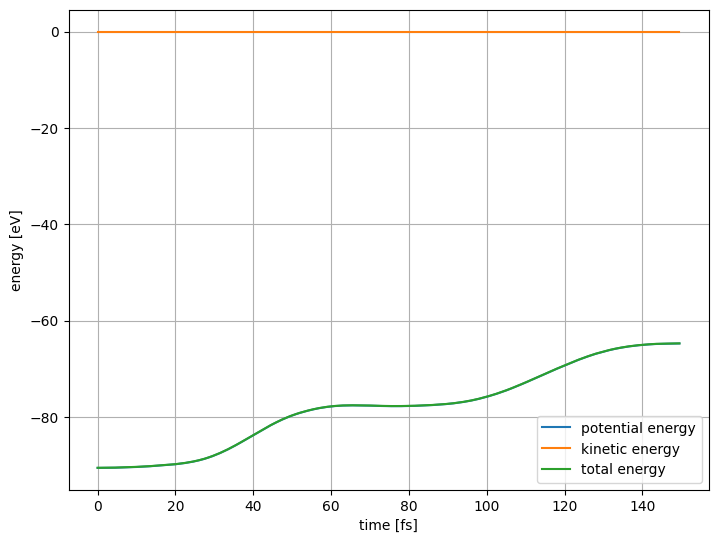

In [163]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

In [164]:
view_atoms(ase_atoms)